# Model Testing Pipeline

Identifying the best model (considered with best parameters of each respectively)
1.   Re-train models using both training and validation data
2.   Evaluate models against the testing data

In [1]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:00
time: 646 µs (started: 2023-03-26 12:32:34 +00:00)


In [2]:
# Basic Libraries

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 27.7 s (started: 2023-03-26 12:32:34 +00:00)


In [3]:
# Data Source

df = pd.read_csv("/content/drive/MyDrive/cleaned_gee_data_v3.csv")
df = df.drop(columns = ['Unnamed: 0'], axis=1)
df.head()

LATITUDE  LONGITUDE  CO_MOL/M2  SO2_MOL/M2  NO2_MOL/M2  O3_MOL/M2  \
0  0.079561   0.356387   0.252793    0.175102    0.048868   0.390066   
1  0.079561   0.356387   0.267145    0.175102    0.048868   0.390066   
2  0.079561   0.356387   0.252793    0.175102    0.041340   0.390066   
3  0.079561   0.356387   0.267145    0.175102    0.041340   0.390066   
4  0.083532   0.351189   0.154547    0.210118    0.045284   0.550787   

   FIRE_OCCURRED  
0              0  
1              0  
2              0  
3              0  
4              0

time: 1.42 s (started: 2023-03-26 12:33:01 +00:00)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171893 entries, 0 to 171892
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LATITUDE       171893 non-null  float64
 1   LONGITUDE      171893 non-null  float64
 2   CO_MOL/M2      171893 non-null  float64
 3   SO2_MOL/M2     171893 non-null  float64
 4   NO2_MOL/M2     171893 non-null  float64
 5   O3_MOL/M2      171893 non-null  float64
 6   FIRE_OCCURRED  171893 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 9.2 MB
time: 31.5 ms (started: 2023-03-26 12:33:03 +00:00)


In [5]:
display(df['FIRE_OCCURRED'].value_counts())

0    170544
1      1349
Name: FIRE_OCCURRED, dtype: int64

time: 12.3 ms (started: 2023-03-26 12:33:03 +00:00)


In [6]:
X = df.drop('FIRE_OCCURRED', axis=1)
y = df['FIRE_OCCURRED']

time: 11.3 ms (started: 2023-03-26 12:33:03 +00:00)


In [7]:
# Training, Testing Split

from sklearn.model_selection import train_test_split

# 90:10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10, shuffle=True)

Original = [X_train, X_test, y_train, y_test] # For reference

time: 277 ms (started: 2023-03-26 12:33:03 +00:00)


In [8]:
if len(X_train)==len(y_train) and len(X_test) == len(y_test):
  print("X and y data length matching")
else:
  print("Error in data preparation pipeline")
print()
print("No. of training data = %d" % len(X_train))
print("No. of testing data = %d" % len(X_test))

X and y data length matching

No. of training data = 154703
No. of testing data = 17190
time: 1.27 ms (started: 2023-03-26 12:33:03 +00:00)


In [9]:
display(y_test.value_counts())

0    17059
1      131
Name: FIRE_OCCURRED, dtype: int64

time: 7.74 ms (started: 2023-03-26 12:33:03 +00:00)


In [10]:
# SMOTE

from collections import Counter
from imblearn.over_sampling import SMOTE 

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=10)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 153485, 1: 1218})
Resampled dataset shape Counter({0: 153485, 1: 153485})
time: 689 ms (started: 2023-03-26 12:33:03 +00:00)


In [11]:
# Shuffle Data since SMOTE appended many 1s at the end
# Required for some algorithms such as ANN

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state = 10)

time: 55 ms (started: 2023-03-26 12:33:04 +00:00)


In [12]:
# Evaluation Metrics

from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, accuracy_score

def evaluation_metrics(y_true, y_pred):
  cfm = confusion_matrix(y_true, y_pred).ravel()
  acc = accuracy_score(y_true, y_pred)
  recs = recall_score(y_true, y_pred, average='binary')
  f1s = f1_score(y_true, y_pred, average='binary')
  rocs = roc_auc_score(y_true, y_pred, average='macro')
  return [cfm, acc, recs, f1s, rocs]

time: 1.65 ms (started: 2023-03-26 12:33:04 +00:00)


Confusion matrix format : [ tn , fp , fn , tp ]

In [13]:
# Store Model Parameters and Eval

models_final = pd.DataFrame(columns = ['model_name', 'model', 'parameters'])
models_test = pd.DataFrame(columns = ['model_name', 'confusion_matrix', 'accuracy', 'recall', 'f1_score', 'roc_auc_score'])

time: 4.87 ms (started: 2023-03-26 12:33:04 +00:00)


In [14]:
# Import ML Algorithms

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import VotingClassifier

# Save Model

import pickle

time: 4.07 s (started: 2023-03-26 12:33:04 +00:00)


## Logistic Regression

- Library: Scikit-learn

**Best Parameters:**

{'warm_start': False,
 'solver': 'lbfgs',
 'penalty': 'l2',
 'max_iter': 200,
 'C': 0.1}

In [ ]:
name = 'log_clf'

log_clf = LogisticRegression(penalty = 'l2', 
                             warm_start = False,
                             solver = 'lbfgs',
                             max_iter = 200,
                             C = 0.1,
                             n_jobs = -1, 
                             random_state = 10
                             ).fit(X_train,y_train)

y_true = y_test
y_pred = log_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': log_clf, 
                        'parameters': log_clf.get_params()}, 
                        ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 2.67 s (started: 2023-03-05 03:16:10 +00:00)


In [ ]:
# Save Model
pickle.dump(log_clf, open('log_clf.sav', 'wb')) 

# Load Model
# log_clf = pickle.load(open('log_clf.sav', 'rb'))

time: 3.1 ms (started: 2023-03-05 03:16:13 +00:00)


## Support Vector Machine (SVM)

- Library: Scikit-learn

**Best Parameters:**

{
'kernel': 'rbf',
'C' : '8',
'class_weight'='balanced'
}

In [ ]:
X_train_SVM = Original[0]
X_test_SVM = Original[1]
y_train_SVM = Original[2]
y_test_SVM = Original[3]

time: 1.35 ms (started: 2023-03-05 03:16:13 +00:00)


In [ ]:
# Shuffle

X_train_SVM, y_train_SVM = shuffle(X_train_SVM, y_train_SVM, random_state = 10)

time: 53.1 ms (started: 2023-03-05 03:16:13 +00:00)


In [ ]:
display(y_train_SVM.value_counts())

0    153485
1      1218
Name: FIRE_OCCURRED, dtype: int64

time: 10.5 ms (started: 2023-03-05 03:16:13 +00:00)


In [ ]:
name = 'svc_clf'

svc_clf = SVC(kernel = 'rbf', 
              C = 8,
              class_weight='balanced',
              random_state = 10
              ).fit(X_train_SVM,y_train_SVM)

y_true = y_test_SVM
y_pred = svc_clf.predict(X_test_SVM)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': svc_clf, 
                        'parameters': svc_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 17min 29s (started: 2023-03-05 03:16:13 +00:00)


In [ ]:
# Save Model
pickle.dump(svc_clf, open('svc_clf.sav', 'wb')) 

# Load Model
# svc_clf = pickle.load(open('svc_clf.sav', 'rb'))

time: 8.64 ms (started: 2023-03-05 03:33:42 +00:00)


## Naive Bayes

- Library: Scikit-learn

**Best Parameters:**

{'var_smoothing': 1e-10}

In [ ]:
name = 'bayes_clf'

bayes_clf = GaussianNB(var_smoothing = 1e-10
                       ).fit(X_train,y_train)

y_true = y_test
y_pred = bayes_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': bayes_clf, 
                        'parameters': bayes_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 105 ms (started: 2023-03-05 03:33:42 +00:00)


In [ ]:
# Save Model
pickle.dump(bayes_clf, open('bayes_clf.sav', 'wb')) 

# Load Model
# bayes_clf = pickle.load(open('bayes_clf.sav', 'rb'))

time: 1.53 ms (started: 2023-03-05 03:33:42 +00:00)


## K-Nearest Neighbor

- Library: Scikit-learn

**Best Parameters:**

{'n_neighbors': 7, 'algorithm': 'ball_tree'}

In [ ]:
name = 'neigh_clf'

neigh_clf = KNeighborsClassifier(n_neighbors = 7, 
                                 algorithm = 'ball_tree',
                                 n_jobs = -1, 
                                 ).fit(X_train,y_train)

y_true = y_test
y_pred = neigh_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': neigh_clf, 
                        'parameters': neigh_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 12.3 s (started: 2023-03-05 03:33:43 +00:00)


In [ ]:
# Save Model
# pickle.dump(neigh_clf, open('neigh_clf.sav', 'wb')) 
pickle.dump(neigh_clf, open('neigh_clf.h', 'wb')) 

# Load Model
# neigh_clf = pickle.load(open('neigh_clf.sav', 'rb'))

time: 28.8 ms (started: 2023-03-05 03:33:55 +00:00)


## Decision Tree

- Library: Scikit-learn

**Best Parameters:**

{'splitter': 'best',
 'min_samples_leaf': 3,
 'max_features': 4,
 'max_depth': None,
 'criterion': 'log_loss'}

In [ ]:
name = 'tree_clf'

tree_clf = DecisionTreeClassifier(criterion = 'log_loss', 
                                  splitter = 'best', 
                                  min_samples_leaf = 3,
                                  max_features = 4,
                                  max_depth = None,
                                  random_state = 10
                                  ).fit(X_train,y_train)

y_true = y_test
y_pred = tree_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': tree_clf, 
                        'parameters': tree_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 2.3 s (started: 2023-03-05 03:33:55 +00:00)


In [ ]:
# Save Model
pickle.dump(tree_clf, open('tree_clf.sav', 'wb')) 

# Load Model
# tree_clf = pickle.load(open('tree_clf.sav', 'rb'))

time: 3.21 ms (started: 2023-03-05 03:33:57 +00:00)


In [ ]:
from sklearn import tree

# tree.plot_tree(tree_clf)

fig = plt.figure(figsize=(200,100))
_ = tree.plot_tree(tree_clf, 
                   feature_names=['LATITUDE','LONGITUDE','ACQ_DATE','ACQ_TIME','OPEN_TIME','CLOSE_TIME','CO_MOL/M2','SO2_MOL/M2','O2_MOL/M2','O3_MOL/M2','LOCATION','INSTRUMENT','DRY_SEASON'],
                   filled=True)

time: 8min 36s (started: 2023-03-05 03:33:57 +00:00)


## Random Forest Classifier

- Library: Scikit-learn

**Best Parameters:**

{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': None}

In [ ]:
name = 'rnd_clf'

rnd_clf = RandomForestClassifier(n_estimators = 300, 
                                  min_samples_split = 6,
                                  min_samples_leaf = 1,
                                  max_features = 2,
                                  max_depth = None, 
                                  n_jobs = -1, 
                                  random_state = 10
                                  ).fit(X_train,y_train)

y_true = y_test
y_pred = rnd_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': rnd_clf, 
                        'parameters': rnd_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 3min 54s (started: 2023-03-05 03:42:34 +00:00)


In [ ]:
# Save Model
pickle.dump(rnd_clf, open('rnd_clf.sav', 'wb')) 


# Load Model
# rnd_clf = pickle.load(open('rnd_clf.sav', 'rb'))

time: 488 ms (started: 2023-03-05 03:46:28 +00:00)


## Gradient Boosting Classifier

- Library: Scikit-learn

**Best Parameters:**

{'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.2}

In [ ]:
name = 'gboost_clf'

gboost_clf = GradientBoostingClassifier(n_estimators = 1000, 
                                        learning_rate = 0.2, 
                                        max_depth = 15,
                                        random_state = 10
                                        ).fit(X_train,y_train)

y_true = y_test
y_pred = gboost_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': gboost_clf, 
                        'parameters': gboost_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 39min 18s (started: 2023-03-05 03:46:28 +00:00)


In [ ]:
# Save Model
pickle.dump(gboost_clf, open('gboost_clf.sav', 'wb')) 
pickle.dump(gboost_clf, open('gboost_clf.h', 'wb')) 

# Load Model
# gboost_clf = pickle.load(open('gboost_clf.sav', 'rb'))

time: 1.2 s (started: 2023-03-05 04:25:47 +00:00)


## XGBoost

- Library: xgboost

**Best Parameters:**

{'n_estimators': 1000,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.25}

In [15]:
name = 'xgboost_clf'

xgboost_clf = XGBClassifier(n_estimators = 1000, 
                            learning_rate = 0.25,
                            max_depth = 10, 
                            min_child_weight = 5,
                            random_state = 10
                            ).fit(X_train,y_train)

y_true = y_test
y_pred = xgboost_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': xgboost_clf, 
                        'parameters': xgboost_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 12min 23s (started: 2023-03-26 12:33:09 +00:00)


<ipython-input-15-79253a1afe95>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_final = models_final.append({'model_name': name,
<ipython-input-15-79253a1afe95>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_test = models_test.append({'model_name': name,


In [16]:
# Save Model
pickle.dump(xgboost_clf, open('xgboost_clf_final.sav', 'wb')) 
pickle.dump(xgboost_clf, open('xgboost_clf_final.h', 'wb')) 

# Load Model
# xgboost_clf = pickle.load(open('xgboost_clf.sav', 'rb'))

time: 87 ms (started: 2023-03-26 12:45:32 +00:00)


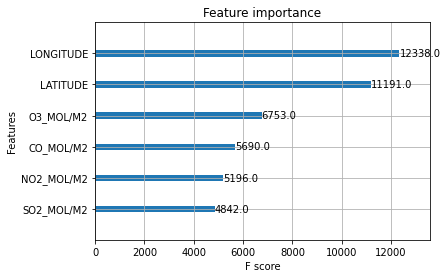

time: 279 ms (started: 2023-03-26 12:45:32 +00:00)


In [17]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(xgboost_clf)
pyplot.show()

## LightGBM

- Library: lightbgm

**Best Parameters:**

{'num_leaves': 200,
 'n_estimators': 1000,
 'min_data_in_leaf': 20,
 'max_depth': 10,
 'learning_rate': 0.05}

In [ ]:
name = 'lightgbm_clf'

lightgbm_clf = LGBMClassifier(n_estimators = 1000, 
                              learning_rate = 0.05, 
                              max_depth = 10,
                              num_leaves = 200,
                              min_data_in_leaf = 20,
                              random_state = 10
                              ).fit(X_train,y_train)

y_true = y_test
y_pred = lightgbm_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': lightgbm_clf, 
                        'parameters': lightgbm_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 44.7 s (started: 2023-03-05 04:36:20 +00:00)


In [ ]:
# Save Model
pickle.dump(lightgbm_clf, open('lightgbm_clf.sav', 'wb')) 
pickle.dump(lightgbm_clf, open('lightgbm_clf.h', 'wb')) 

# Load Model
# lightgbm_clf = pickle.load(open('lightgbm_clf.sav', 'rb'))

## Artificial Neural Network

- Library: Keras, Tensorflow

**Best Parameters:**
- Batch size 5
- EPOCH 80

In [ ]:
tf.random.set_seed(10)

In [ ]:
name = 'ann_clf'

ann_clf = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
    # keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')
])

ann_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                105       
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________
time: 340 ms (started: 2023-03-05 04:37:07 +00:00)


In [ ]:
display(y_train.value_counts())

1    153485
0    153485
Name: FIRE_OCCURRED, dtype: int64

time: 18 ms (started: 2023-03-05 04:37:07 +00:00)


In [ ]:
display(y_test.value_counts())

0    17059
1      131
Name: FIRE_OCCURRED, dtype: int64

time: 12.5 ms (started: 2023-03-05 04:37:07 +00:00)


In [ ]:
ann_clf.compile(optimizer = 'adam', 
                metrics=['accuracy'], 
                loss ='binary_crossentropy')

record = ann_clf.fit(
            X_train, 
            y_train, 
            validation_data = (X_test, y_test), 
            batch_size = 5, 
            epochs = 80)

Epoch 1/80
61394/61394 [==============================] - 159s 3ms/step - loss: 0.4855 - accuracy: 0.7571 - val_loss: 0.3479 - val_accuracy: 0.8247
Epoch 2/80
61394/61394 [==============================] - 153s 2ms/step - loss: 0.4248 - accuracy: 0.8039 - val_loss: 0.4436 - val_accuracy: 0.7547
Epoch 3/80
61394/61394 [==============================] - 153s 2ms/step - loss: 0.4087 - accuracy: 0.8140 - val_loss: 0.3720 - val_accuracy: 0.8235
Epoch 4/80
61394/61394 [==============================] - 154s 3ms/step - loss: 0.4004 - accuracy: 0.8176 - val_loss: 0.4066 - val_accuracy: 0.7970
Epoch 5/80
61394/61394 [==============================] - 152s 2ms/step - loss: 0.3937 - accuracy: 0.8216 - val_loss: 0.3007 - val_accuracy: 0.8678
Epoch 6/80
61394/61394 [==============================] - 158s 3ms/step - loss: 0.3849 - accuracy: 0.8266 - val_loss: 0.4000 - val_accuracy: 0.8190
Epoch 7/80
61394/61394 [==============================] - 154s 3ms/step - loss: 0.3802 - accuracy: 0.8303 - val_

In [ ]:
y_true = y_test
prediction = ann_clf.predict(X_test)
prediction = pd.Series(prediction[:, 0])
y_pred = []

for i in range(len(prediction)):
  if prediction[i] >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': ann_clf, 
                        'parameters': ann_clf.layers}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

538/538 [==============================] - 1s 2ms/step
time: 3.23 s (started: 2023-03-05 08:04:33 +00:00)


In [ ]:
# Save Model
ann_clf.save('ann_clf.h5') 

# Load Model
# ann_clf = tf.keras.models.load_model('ann_clf.h5')

time: 81.9 ms (started: 2023-03-05 08:04:36 +00:00)


## Voting Classifier
- Library: Scikit-learn, Keras, Tensorflow

**Best Parameters:**

{'voting': 'soft'}

In [ ]:
display(models_test)

model_name        confusion_matrix  accuracy    recall  f1_score  \
0       log_clf   [10479, 6580, 47, 84]  0.614485  0.641221  0.024724   
1       svc_clf   [14472, 2587, 32, 99]  0.847644  0.755725  0.070288   
2     bayes_clf   [10245, 6814, 56, 75]  0.600349  0.572519  0.021368   
3     neigh_clf    [16680, 379, 32, 99]  0.976091  0.755725  0.325123   
4      tree_clf   [16936, 123, 28, 103]  0.991216  0.786260  0.577031   
5       rnd_clf    [17002, 57, 29, 102]  0.994997  0.778626  0.703448   
6    gboost_clf    [17007, 52, 24, 107]  0.995579  0.816794  0.737931   
7   xgboost_clf    [16994, 65, 25, 106]  0.994764  0.809160  0.701987   
8  lightgbm_clf   [16944, 115, 30, 101]  0.991565  0.770992  0.582133   
9       ann_clf  [14751, 2308, 21, 110]  0.864514  0.839695  0.086308   

   roc_auc_score  
0       0.627751  
1       0.802038  
2       0.586541  
3       0.866754  
4       0.889525  
5       0.887642  
6       0.906873  
7       0.902675  
8       0.882126  
9       0.852200

time: 25 ms (started: 2023-03-05 08:04:36 +00:00)


In [ ]:
print('Best Model By Accuracy')
print(models_test.loc[models_test['accuracy'] == max(models_test['accuracy'])].model_name.to_string(index=False))
print('-----------------------')
print('Best Model By Recall')
print(models_test.loc[models_test['recall'] == max(models_test['recall'])].model_name.to_string(index=False))
print('-----------------------')
print('Best Model By F1')
print(models_test.loc[models_test['f1_score'] == max(models_test['f1_score'])].model_name.to_string(index=False))
print('-----------------------')
print('Best Model By ROC')
print(models_test.loc[models_test['roc_auc_score'] == max(models_test['roc_auc_score'])].model_name.to_string(index=False))
print('-----------------------')

Best Model By Accuracy
gboost_clf
-----------------------
Best Model By Recall
ann_clf
-----------------------
Best Model By F1
gboost_clf
-----------------------
Best Model By ROC
gboost_clf
-----------------------
time: 24.3 ms (started: 2023-03-05 08:04:36 +00:00)


In [ ]:
name = 'ensem_clf'

ensem_clf = VotingClassifier(estimators=[('m1', neigh_clf), ('m2', lightgbm_clf), ('m3', xgboost_clf)],
                             voting = 'soft',
                             n_jobs = -1, 
                             ).fit(X_train,y_train)

y_true = y_test
y_pred = ensem_clf.predict(X_test)
evaluation_results = evaluation_metrics(y_true, y_pred)

models_final = models_final.append({'model_name': name, 
                        'model': ensem_clf, 
                        'parameters': ensem_clf.get_params()}, 
                       ignore_index=True)

models_test = models_test.append({'model_name': name, 
                                  'confusion_matrix' : evaluation_results[0], 
                                  'accuracy': evaluation_results[1], 
                                  'recall' : evaluation_results[2], 
                                  'f1_score': evaluation_results[3],
                                  'roc_auc_score': evaluation_results[4]}, 
                                 ignore_index=True)

time: 12min 52s (started: 2023-03-05 08:04:36 +00:00)


In [ ]:
# Save Model
pickle.dump(ensem_clf, open('ensem_clf.sav', 'wb')) 

# Load Model
# ensem_clf = pickle.load(open('ensem_clf.sav', 'rb'))

# Model Testing Result

### Results

In [18]:
display(models_final)

model_name                                              model  \
0  xgboost_clf  XGBClassifier(base_score=None, booster=None, c...   

                                          parameters  
0  {'objective': 'binary:logistic', 'use_label_en...

time: 16.4 ms (started: 2023-03-26 12:45:33 +00:00)


In [19]:
display(models_test)

model_name      confusion_matrix  accuracy   recall  f1_score  \
0  xgboost_clf  [16994, 65, 25, 106]  0.994764  0.80916  0.701987   

   roc_auc_score  
0       0.902675

time: 18.2 ms (started: 2023-03-26 12:45:33 +00:00)


In [ ]:
print('Best Model By Accuracy')
print(models_test.loc[models_test['accuracy'] == max(models_test['accuracy'])].model_name.to_string(index=False))
print('-----------------------')
print('Best Model By Recall')
print(models_test.loc[models_test['recall'] == max(models_test['recall'])].model_name.to_string(index=False))
print('-----------------------')
print('Best Model By F1')
print(models_test.loc[models_test['f1_score'] == max(models_test['f1_score'])].model_name.to_string(index=False))
print('-----------------------')
print('Best Model By ROC')
print(models_test.loc[models_test['roc_auc_score'] == max(models_test['roc_auc_score'])].model_name.to_string(index=False))
print('-----------------------')

# Model Export

In [20]:
from google.colab import files

time: 717 µs (started: 2023-03-26 12:45:33 +00:00)


In [21]:
files.download('xgboost_clf_final.sav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 7.54 ms (started: 2023-03-26 12:45:33 +00:00)


In [22]:
files.download('xgboost_clf_final.h')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 6.53 ms (started: 2023-03-26 12:45:33 +00:00)


# Test Predict Function

In [36]:
data = [[0.706985032, 0.151576852, 0.2, 0.191972337, 0.1328319, 0.348305153], 
        [0.706985032, 0.151576852, 0.5, 0.191972337, 0.1328319, 0.348305153], 
        [0.706985032, 0.151576852, 1.0, 0.191972337, 0.1328319, 0.348305153]]
df = pd.DataFrame(data, columns=['LATITUDE','LONGITUDE','CO_MOL/M2','SO2_MOL/M2','NO2_MOL/M2','O3_MOL/M2'])

xgboost_clf.predict(df)

array([1, 0, 0])

time: 68 ms (started: 2023-03-26 12:56:27 +00:00)
